In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from matplotlib.patches import Rectangle
from datetime import datetime
# sns.set()

# Introduction <a id='intro'></a>

This notebook cleans and wrangles numerous data sets, making them uniform
so that they can be used in a data-driven model for COVID-19 prediction.

The key cleaning measures are those which find the most viable set of countries and date ranges
such that the maximal amount of data can be used. In other words, different datasets can have data
on a different set of countries; to avoid introducing large quantities of missing values
the intersection of these countries is taken. For the date ranges, depending on the quantity,
extrapolation/interpolation is used to ensure that each time series is defined to be non-zero
on all dates. 


# Table of contents<a id='toc'></a>

## [Data wrangling function definitions](#generalfunctions)

# Data <a id='data'></a>

            -->
## [JHU CSSE case data.](#csse)
[https://systems.jhu.edu/research/public-health/ncov/](https://systems.jhu.edu/research/public-health/ncov/)

**Data available at:**
[https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

This data is split between a collection of .csv files of two different formats; first, the daily reports (global) are
separated by day, each residing in their own .csv. Additionally, the daily report files have three different formats that need to be taken into account when compiling the data. The daily report data itself contains values on the number of confirmed cases, deceased, active cases, recovered cases.

For the other format, .csv files with 'timeseries' in their filename, the data contains values for confirmed, deceased, recovered and are split between global numbers (contains United States as a whole) and numbers for the united states (statewide).
           
           
## [OWID case and test data](#owid)

**Data available via github**
[https://github.com/owid/covid-19-data](https://github.com/owid/covid-19-data)

[https://ourworldindata.org/covid-testing](https://ourworldindata.org/covid-testing)

The OWID dataset contains information regarding case and test numbers; it overlaps with the JHU CSSE 
and Testing Tracker datasets but I am going to attempt to use it in conjunction with those two because
of how there is unreliable reporting. In other words to get the bigger picture I'm looking to stitch together
multiple datasets.

           
## [OxCGRT government response data](#oxcgrt)

**Data available at:**
[https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv](https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv)


**If API used to pull data (I elect not to because the datasets are different)**
[https://covidtracker.bsg.ox.ac.uk/about-api](https://covidtracker.bsg.ox.ac.uk/about-api)

The OxCGRT dataset contains information regarding different government responses in regards to social
distancing measures. It measures the type of social distancing measure, whether or not they are recommended
or mandated, whether they are targeted or broad (I think geographically). 
           
## [Testing tracker data](#testtrack)
<!-- **Website which lead me to dataset**
[https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/](https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/) -->

**Data available at:**
[https://finddx.shinyapps.io/FIND_Cov_19_Tracker/](https://finddx.shinyapps.io/FIND_Cov_19_Tracker/)

This dataset contains a time series of testing information: e.g. new (daily) tests, cumulative tests, etc. 


# [Data regularization: making things uniform](#uniformity)

### [Intersection of countries](#country)
  
### [Time series date ranges](#time)

### [Missing Values](#missingval)

## Data wrangling function declaration <a id='generalfunctions'></a>


In [2]:

def country_search(df, country):
    return df[df.location==country].index

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool|
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                        re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                     re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values



In [3]:
#----------------- Helper Functions for cleaning ----------------------#


#----------------- Helper Functions for regularization ----------------------#
def intersect_country_index(df, country_intersection):
    df_tmp = df.copy().reset_index(level=0)
    df_tmp = df_tmp[df_tmp.location.isin(country_intersection)]
    df_tmp = df_tmp.set_index(['location', df_tmp.index])
    return df_tmp 

def resample_dates(df, dates):
    df = df.loc[~df.index.duplicated(keep='first')]
    return df.reindex(pd.MultiIndex.from_product([df.index.levels[0], dates], names=['location', 'date']), fill_value=np.nan)

def make_multilevel_columns(df):
    df.columns = pd.MultiIndex.from_product([[df.columns.name], df.columns], names=['dataset', 'features'])
    return df

def multiindex_to_table(df):
    df_table = df.copy()
    try:
        df_table.columns = df_table.columns.droplevel()
        df_table.columns.names = ['']
    except:
        pass
    df_table = df_table.reset_index()
    return df_table

#----------------- Manipulation flagging ----------------------#


def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df



def add_time_indices(data_table, index_column='cases'):
    indexer = data_table.loc[:, ['location', index_column]].replace(to_replace=0, value=np.nan).dropna().reset_index()
    country_groupby_indices = country_groupby(data_table)
    country_groupby_indices_dropped_nan = country_groupby(indexer)
    days_since = []
    for i, c in enumerate(country_groupby_indices_dropped_nan):
        nonzero_list = list(range(len(c)))
        zero_list = 0*np.array(list(range(len(country_groupby_indices[i])-len(c))))
        days_since += list(zero_list)+nonzero_list

    data_table.loc[:, 'days_since_first_case'] = days_since
    data_table.loc[:, 'time_index'] = len(data_table.location.unique())*list(range(len(data_table.date.unique())))
    return data_table


def regularize_time_series(df_list):
    country_intersection = df_list[0].index.levels[0].unique()
    dates_union =  df_list[0].index.levels[1].unique()
    dates_intersection =  df_list[0].index.levels[1].unique()

    for i in range(len(df_list)-1):
        country_intersection = country_intersection.intersection(df_list[i+1].index.levels[0].unique())
        dates_union = dates_union.union(df_list[i+1].index.levels[1].unique())
        # not really intersection, this is the minimum date that at least one country has data for, in each dataset.
        dates_intersection = dates_intersection.intersection(df_list[i+1].index.levels[1].unique())

    df_list_intersected = [intersect_country_index(df, country_intersection) for df in df_list]

    #This redefines the time series for all variables as from December 31st 2019 to the day with most recent data
    time_normalized_global_data = [resample_dates(df, dates_intersection.normalize()) for df in df_list_intersected]
    # To keep track of which data came from where, make the columns multi level with the first level labelling the dataset.
    return time_normalized_global_data, dates_intersection, country_intersection



def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        rollstd = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
                rollstd = df.loc[c, features].rolling(window).std().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
                rollstd = pd.concat((rollstd,  df.loc[c,features].rolling(window).std().fillna(value=0.)),axis=0)

        new_features = pd.concat((rollmean, rollstd), axis=1)
#         new_features = rollmean
#         new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         new_cols = mean_cols

        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list,axis=1)



def tsplot(pd_series, roll_width, **kw):
    fig, ax = plt.subplots(figsize=(10,5))
    rollmean = pd_series.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
    rollstd  = pd_series.rolling(roll_width).std().fillna(method='backfill').values.ravel()
    cis = (rollmean - rollstd, rollmean + rollstd)
    ax.fill_between(range(len(pd_series)), cis[0], cis[1], alpha=0.5)
    ax.plot(range(len(pd_series)), rollmean, color='k')
    return ax



def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df


def fix_incorrect_decrease(df, feature, search_threshold='match'):
    df_tmp = df.copy()
    matching_columns = column_search(df_tmp, feature, return_style='iloc', threshold=search_threshold) 
    feature_index =  matching_columns[df_tmp.iloc[:, matching_columns].isna().sum().argmin()]
    location_index =  column_search(df_tmp, 'location', return_style='iloc', threshold=search_threshold)[0] 
    decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
    n_countries_with_missing = len(df_tmp.iloc[decreasing_indices, location_index].unique().tolist())
    print('Fixing {} countries in the ''{}'' column feature'.format(
        n_countries_with_missing, df_tmp.iloc[:, feature_index].name)) 
    # premptive filling, not related to decreasing but rather missing values.
    decreasing_incorrectly = []
    flag = True
    
    # flag is switched off immediately, but will be switched on if any values are changed.
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    while flag:
        flag = False
        decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
        if decreasing_indices.size > 0:
            countries_with_missing = df_tmp.iloc[decreasing_indices, location_index].unique().tolist()
            flag = True
            df_tmp.iloc[decreasing_indices, feature_index] = np.nan
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    return df_tmp

def rolling_means(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
#         rollmean = pd.DataFrame(df..groupby(by='location').rolling(window).mean().fillna(value=0.))
#         rollstd = pd.DataFrame(df.groupby(by='location').rolling(window).std().fillna(value=0.))    
#         new_features = pd.concat((rollmean, rollstd), axis=1)
        new_features = rollmean
        new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         rsind = features +'_rolling_std_' + str(window)
#         new_cols = rmind.append(rsind)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return new_feature_df_list

In [4]:
df_list = []

#the actual format difference is being covered up by pd.concat which fills with Nans
for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/*.csv'):
    tmp_df = pd.read_csv(x)
    tmp_df.columns = reformat_values(tmp_df.columns, category='columns').values
    df_list.append(tmp_df)

daily_reports_df = pd.concat(df_list, axis=0)
daily_reports_df.columns = reformat_values(daily_reports_df.columns, category='columns').values
daily_reports_df.loc[:, 'date'] = reformat_values(daily_reports_df.loc[:, 'last_update'], category='date').values
daily_reports_df.loc[:, 'location'] =  reformat_values(daily_reports_df.loc[:, 'country_region'], category='location').values

In [5]:
daily_reports_df.loc[:, 'combined_key'] = (daily_reports_df.province_state.astype('str').replace(to_replace='nan', value='')+' '+ daily_reports_df.location.astype('str')).values

In [6]:
daily_reports_df = daily_reports_df.drop(columns=['province_state', 'last_update', 'fips', 'admin2']).set_index(['location','date'])


In [7]:
daily_reports_df.sample(5)

country_region  confirmed  deaths  recovered  \
location      date                                                      
United States 2020-05-10             US        9.0     0.0        0.0   
              2020-04-08             US       18.0     1.0        0.0   
              2020-05-30             US       54.0    10.0        0.0   
              2020-05-26             US        9.0     0.0        0.0   
              2020-05-07             US        8.0     0.0        0.0   

                          latitude  longitude        lat        long  active  \
location      date                                                             
United States 2020-05-10       NaN        NaN  41.197743 -103.714813     9.0   
              2020-04-08       NaN        NaN  32.366160  -81.342809     0.0   
              2020-05-30       NaN        NaN  46.433891  -87.640437    44.0   
              2020-05-26       NaN        NaN  44.642529 -123.869912     9.0   
              2020-05-07       NaN        NaN  35.203839  -82.796384     8.0   

                                          combined_key  incidence_rate  \
location      date                                                       
United States 2020-05-10        Nebraska United States             NaN   
              2020-04-08         Georgia United States             NaN   
              2020-05-30        Michigan United States       80.960734   
              2020-05-26          Oregon United States             NaN   
              2020-05-07  North Carolina United States             NaN   

                          case-_fatality_ratio  
location      date                              
United States 2020-05-10                   NaN  
              2020-04-08                   NaN  
              2020-05-30             18.518519  
              2020-05-26                   NaN  
              2020-05-07                   NaN

## Data Reformatting

The following sections take the corresponding data set and reformat them such that the data
is stored in a pandas DataFrame with a multiindex; level=0 -> 'location' (country or region) and
level=1 -> date. Due to the nature of the data this is done separately for country-wide and united states-wide locations.

## JHU CSSE case data
<a id='csse'></a>
[Return to table of contents](#toc)

Tasks / to-do for this data set.

In [8]:
global_df_list = []

for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_global.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :4]
    datecols = tmp_df.iloc[:, 4:]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  reformat_values(catcols.loc[:, 'country_region'], category='location').values
    datecols.columns = reformat_values(datecols.columns, category='date').values
    global_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    global_df_list.append(global_tmp.stack().to_frame(name=time_series_name))



csse_global_time_series_df = pd.concat(global_df_list, axis=1)#.reset_index(drop=True)
csse_global_time_series_df.index.names = ['location','date']
csse_global_time_series_df.columns.names = ['csse_global_timeseries']
csse_global_time_series_df.columns = ['cases', 'deaths', 'recovered']

In [9]:
csse_global_time_series_df.sample(5)

,,cases,deaths,recovered
location,date,,,
Ivory Coast,2020-05-29 00:00:00,2750,32,1370
Ethiopia,2020-05-06 00:00:00,162,4,93
Lesotho,2020-02-04 00:00:00,0,0,0
Afghanistan,2020-04-22 00:00:00,1176,40,166
Cuba,2020-04-30 00:00:00,1501,61,681


In [10]:
usa_df_list = []
for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_US.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :np.where(tmp_df.columns == '1/22/20')[0][0]]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  catcols.loc[:, 'province_state'].values
    
    datecols = tmp_df.iloc[:,np.where(tmp_df.columns == '1/22/20')[0][0]:]
    datecols.columns = reformat_values(datecols.columns, category='date').values
    usa_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    usa_df_list.append(usa_tmp.stack().to_frame(name=time_series_name))
    
usa_time_series_df = pd.concat(usa_df_list,axis=1)#.reset_index(drop=True)
usa_time_series_df.index.names = ['location','date']
usa_time_series_df.columns.names = ['csse_us_timeseries']


In [11]:
usa_time_series_df.sample(5)

,csse_us_timeseries,confirmed,deaths
location,date,,
Indiana,2020-06-03 00:00:00,35712,2207
Nebraska,2020-02-02 00:00:00,0,0
Kansas,2020-06-21 00:00:00,12136,257
Diamond Princess,2020-02-28 00:00:00,0,0
Alaska,2020-02-17 00:00:00,0,0


## OWID case and test data
<a id='source5'></a>
[Return to table of contents](#toc)

The "Our World in Data" dataset contains time series information on the cases, tests, and deaths.

In [12]:
owid_df =pd.read_csv('./covid-19-data/public/data/owid-covid-data.csv')
# owid_df= owid_df[owid_df.new_cases_per_million > 0])#.new_cases_per_thousand.
owid_df = regularize_names(owid_df, datekey='date', locationkey='location').set_index(['location', 'date']).sort_index()

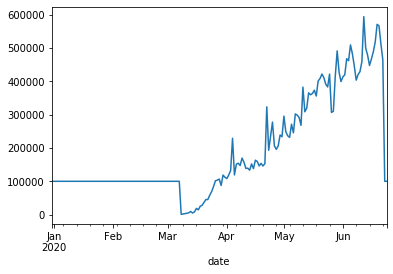

In [13]:
owid_df.loc['United States','new_tests'].fillna(100000).plot()

In [14]:
owid_df.sample(5)

,,iso_code,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
location,date,,,,,,,,,,,,,,,,,,,,,
Brunei,2020-04-21,BRN,Asia,138.0,0.0,1.0,0.0,315.441,0.000,2.286,0.000,...,2.382,71809.251,NaN,201.285,12.79,2.0,30.9,NaN,2.7,75.86
Sudan,2020-05-31,SDN,Africa,4800.0,279.0,262.0,29.0,109.466,6.363,5.975,0.661,...,2.034,4466.507,NaN,431.388,15.67,NaN,NaN,23.437,0.8,65.31
Myanmar,2020-06-01,MMR,Asia,228.0,4.0,6.0,0.0,4.190,0.074,0.110,0.000,...,3.120,5591.597,6.4,202.104,4.61,6.3,35.2,79.287,0.9,67.13
Germany,2020-03-12,DEU,Europe,1567.0,271.0,3.0,1.0,18.703,3.235,0.036,0.012,...,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33
Moldova,2020-03-18,MDA,Europe,30.0,1.0,0.0,0.0,7.437,0.248,0.000,0.000,...,6.955,5189.972,0.2,408.502,5.72,5.9,44.6,86.979,5.8,71.90


## OxCGRT government response data
<a id='oxcgrt'></a>
[Return to table of contents](#toc)

Manual importation of data (for whatever reason this data set is different from pulling using API). This
dataset contains time series information for the different social distancing and quarantine measures. The time
series are recorded using flags which indicate whether or not a measure is in place, recommended, or not considered.
In addition, there are addition flags which augment these time series; indicating whether or not the measures are targeted
or general.

In [15]:
oxcgrt_df = regularize_names(pd.read_csv('./covid-policy-tracker/data/OxCGRT_latest.csv'), locationkey='country_name')
oxcgrt_df.loc[:, 'date'] = pd.to_datetime(oxcgrt_df.loc[:, 'date'], format='%Y%m%d')
oxcgrt_df = oxcgrt_df.set_index(['location', 'date'])
# oxcgrt_df = oxcgrt_df.drop(columns='m1_wildcard')

In [16]:
oxcgrt_df.stringency_index.nunique()

156

In [17]:
oxcgrt_df.sample(5)

,,country_name,country_code,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,c4_flag,...,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
location,date,,,,,,,,,,,,,,,,,,,,,
Andorra,2020-05-23,Andorra,AND,3.0,1.0,2.0,1.0,1.0,1.0,0.0,NaN,...,50.00,50.00,72.62,72.62,61.54,61.54,54.55,54.55,100.0,100.0
Belize,2020-02-29,Belize,BLZ,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,11.11,11.11,14.29,14.29,7.69,7.69,9.09,9.09,0.0,0.0
Djibouti,2020-02-28,Djibouti,DJI,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Andorra,2020-01-31,Andorra,AND,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Greenland,2020-04-21,Greenland,GRL,3.0,0.0,2.0,1.0,2.0,1.0,3.0,1.0,...,81.48,81.48,88.10,88.10,71.79,71.79,84.85,84.85,0.0,0.0


Reformat the data, making it a multiindex dataframe which matches the others in this notebook. Also, cast
the date-like variable as a datetime feature.

## Testing tracker data
<a id='testtrack'></a>
[Return to table of contents](#toc)

This dataset only pertains to testing data of different locations. 

In [18]:
test_tracker = regularize_names(pd.read_csv('test_tracker.csv'),
                          datekey='date', locationkey='country').set_index(
                            ['location', 'date']).drop(
                                    columns=['country','population','alpha3']).sort_index()

In [19]:
test_tracker.sample(5)

,,new_tests,tests_cumulative,tests_per100k,source,cases,new_cases,deaths,cases_per100k,deaths_per100k,income_group,continent,region
location,date,,,,,,,,,,,,
Liechtenstein,2020-04-22,NaN,NaN,NaN,NaN,81.0,0.0,1.0,213.2,2.6,High income,Europe,Western Europe
Australia,2020-05-23,21580.0,1192262.0,4675.5,https://www.health.gov.au/news/health-alerts/n...,7114.0,15.0,102.0,27.9,0.4,High income,Oceania,Australia and New Zealand
Singapore,2020-03-30,0.0,39000.0,666.7,NaN,879.0,35.0,3.0,15.0,0.1,High income,Asia,South-eastern Asia
Spain,2020-06-06,0.0,1919411.0,4105.3,NaN,241310.0,332.0,27135.0,516.1,58.0,High income,Europe,Southern Europe
Singapore,2020-01-30,NaN,NaN,NaN,NaN,10.0,3.0,0.0,0.2,0.0,High income,Asia,South-eastern Asia


## Data regularization: making things uniform <a id='uniformity'></a>

## Intersection of countries in all DataFrames
<a id='country'></a>
[Return to table of contents](#toc)

The data that will be used to model country-wide case numbers exists in the DataFrames : 

    csse_global_daily_reports_df
    csse_global_timeseries_df
    owid_df
    oxcgrt_df
    testtrack_df
    
The index (locations) were not reformatted by default; do that now.

The data have all been formatted to have multi level indices and columns; the levels of the index are ```['location', 'date']``` which correspond to geographical location and day of record. I find it convenient to put these DataFrames into
an iterable (list specifically).

In [20]:
global_data = [csse_global_time_series_df, test_tracker, oxcgrt_df, owid_df]

The first step is to correct the differences in naming conventions so that equivalent countries in fact have the same labels.

The next step is to find the subset of all countries which exist in all of the DataFrames. It is possible to
simply concatenate the data and introduce missing values, however, I am electing to take the intersection of countries as
to take the most "reliable" subset. On the contrary, for the dates I take the union; that is, the dates that exist in all datasets. 

# Data preprocessing and exploration

In [21]:
names = ['jhucsse','testtracker',  'oxcgrt', 'owid']
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(global_data)
print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of countries included is {}'.format(len(country_intersection)))

for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)

eda_data = multiindex_to_table(pd.concat(export_list, axis=1))
eda_data = add_time_indices(eda_data, index_column='cases_jhucsse')
eda_data.to_csv('eda_data.csv')

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-23 00:00:00
The final number of countries included is 150


In [22]:
for country_indices in country_groupby(eda_data):
    eda_data.loc[country_indices, column_search(eda_data,'population')] = \
    eda_data.loc[country_indices,  column_search(eda_data,'population')].fillna(method='ffill').fillna(method='bfill').values 

In [23]:
dataframe_list, modeling_dates, modeling_countries = regularize_time_series(global_data)
print('The range of all dates is from {} to {}'.format(modeling_dates.min(), modeling_dates.max()))
print('The number of countries included is {}'.format(len(modeling_countries)))
# Convert the multiindex DataFrame to a simple table, and then add numerical features which track the
# date and # of days since first case. 
df = add_time_indices(multiindex_to_table(pd.concat(dataframe_list, axis=1)), index_column='cases')

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-23 00:00:00
The number of countries included is 150


To show why these features need to be fixed in order to be cumulative. 

In [24]:
cumulative_columns = pd.Index(column_search(df, 'cases').unique().tolist()
                      +column_search(df, 'deaths').unique().tolist()
                      +column_search(df, 'tests').unique().tolist()+['recovered'])
cumulative_columns = cumulative_columns[~cumulative_columns.str.contains('new')].drop('tests_units')
cumulative_columns

Index(['cases', 'cases_per100k', 'confirmed_cases', 'total_cases',
       'total_cases_per_million', 'deaths', 'deaths_per100k',
       'confirmed_deaths', 'total_deaths', 'total_deaths_per_million',
       'tests_cumulative', 'tests_per100k', 'total_tests',
       'total_tests_per_thousand', 'recovered'],
      dtype='object')

Time series for these four countries, before any manipulations.

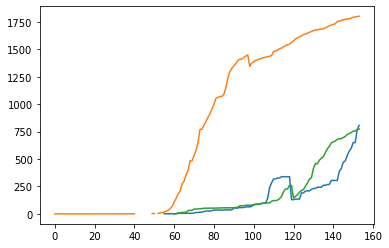

In [25]:
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].total_cases.values)
ax.plot(df[df.location == 'Lithuania'].total_cases.values)
ax.plot(df[df.location == 'Uganda'].total_cases.values)

In [26]:
countries_with_total_cases_incorrect = df[(df.set_index([df.time_index, df.location]).loc[:, cumulative_columns
                                              ].groupby(level=1).diff(1).fillna(0) < 0).total_cases.values].location.unique()#.sum()

In [27]:
(df.set_index([df.time_index, df.location]).loc[:, cumulative_columns
                                              ].groupby(level=1).diff(1).fillna(0) < 0).sum()#.drop_duplicates()

cases                       31
cases                       31
cases_per100k               25
confirmed_cases             14
total_cases                 14
total_cases_per_million     14
deaths                      23
deaths                      23
deaths_per100k              11
confirmed_deaths             1
total_deaths                 1
total_deaths_per_million     1
tests_cumulative            16
tests_per100k               16
total_tests                  5
total_tests_per_thousand     5
recovered                   47
dtype: int64

In [28]:
for features in cumulative_columns:
    df = fix_incorrect_decrease(df, features, search_threshold='match')


Fixing 20 countries in the cases column feature
Fixing 16 countries in the cases_per100k column feature
Fixing 10 countries in the confirmed_cases column feature
Fixing 10 countries in the total_cases column feature
Fixing 10 countries in the total_cases_per_million column feature
Fixing 17 countries in the deaths column feature
Fixing 9 countries in the deaths_per100k column feature
Fixing 1 countries in the confirmed_deaths column feature
Fixing 1 countries in the total_deaths column feature
Fixing 1 countries in the total_deaths_per_million column feature
Fixing 13 countries in the tests_cumulative column feature
Fixing 13 countries in the tests_per100k column feature
Fixing 2 countries in the total_tests column feature
Fixing 2 countries in the total_tests_per_thousand column feature
Fixing 38 countries in the recovered column feature


This is due to errors in reporting, I want to fix these issues before moving on.

## Regularization of time series dates
<a id='time'></a>
[Return to table of contents](#toc)

## Preprocessing: missing values, feature production, etc.
<a id='missingval'></a>
[Return to table of contents](#toc)

The next section is concerned with the handling and imputation of missing values. The key consideration is
to not contaminate the time series with information from the future. Because I am filling in the missing values here,
I will be flagging the original missing values and keeping these flags as new features. Before I can compute these new features I need to think ahead towards the modeling phase of this project, that is, to take into consideration the features which
are to be predicted.

Specifically, I will be modelling and predicting new case numbers.

# Regression data


# CNN data

In [29]:
df.population_density.nunique(), df.location.nunique()

(149, 150)

First, we need to figure out the units of the population densities, for consistency.

This aligns with the population density being in units of people / km^2, per Google search.

## Data quality related exploration

    Differences in reporting 
    differences in time series.


## COVID related exploration

    Death rate estimation. 
    testing vs cases vs deaths
    log-log plot for current growth trends
    bollinger bands
    Differences in government responses (early vs late)
    histogram of trending upwards, flat, downwards
    tools, different plots, correlation plots scatter matrix plots. 

Because I am aggregating a number of different data sets, there are multiple features describing the same quantities (number of cases, deaths, etc.). The quality of the different sources varies, which informs the decision as to which of these columns to keep. This will be explored in more detail later.

My original idea was to normalize using the population of each country but I'm unsure as to whether this is the best
idea; at least without another consideration. Using the population blindly results in micro-states and small countries
being weighted heavily. Now, either I can drop these countries or I can weight the features differently; with the population *density*. This accounts for population as well as how large the state is.

## Feature production, deciding on which features to use for modeling<a id='newfeatures'></a>

In [30]:
# redundant features; some features contain the same substring but are not redundant, hence the use of .difference()
redundant_death_columns = column_search(df, 'death').difference(['cvd_death_rate'])
redundant_test_columns = column_search(df, 'test').difference(['tests_units','h2_testing_policy'])
redundant_case_columns= column_search(df, 'cases')

Before any feature production or investigation, fix the incorrect decreases in these four important columns.

I want to normalize by population, so first I need to fill in the missing values introduced by time series regularization / extrapolation; an additional manipulation is required for population density, namely, the population density feature is missing information on a single country: Afghanistan.

In [31]:
# To prevent the SettingCopyWithSlice warning use loc, which needs index values, hence
# the application of this workaround function. 
# df.loc[country_search(df, 'Afghanistan'), 'population_density'] = 154
# df.loc[country_search(df, 'Kosovo'), 'population_density'] = 159
eda_data.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3
df.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3
# df.loc[country_search(df, 'Guinea Bissau'), 'population'] = \
# df.loc[country_search(df, 'Guinea Bissau'), 'population'].max()

df.loc[country_search(df, 'Guinea Bissau'), 'population_density'] = \
df.loc[country_search(df, 'Guinea Bissau'), 'population_density'].max()


for country_indices in country_groupby(df):
    df.loc[country_indices, ['population','population_density']] = \
    df.loc[country_indices,  ['population','population_density']].fillna(method='ffill').fillna(method='bfill').values 

# df = df[df.population > df.population.quantile(0.1)]
per_million_population = df.population / 1000000.
population_density = df.population_density
world_pop = df[df.time_index==df.time_index.max()].population.sum()
percent_pop = df.population / world_pop

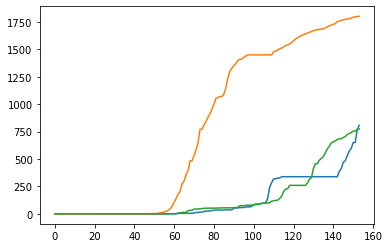

In [32]:
# df = fix_incorrect_decrease(df, 'total_cases', search_threshold='match')
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].total_cases.values)
ax.plot(df[df.location == 'Lithuania'].total_cases.values)
ax.plot(df[df.location == 'Uganda'].total_cases.values)

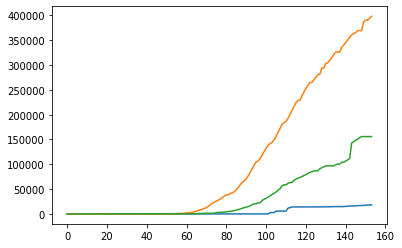

In [33]:
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].tests_cumulative.values)
ax.plot(df[df.location == 'Lithuania'].tests_cumulative.values)
ax.plot(df[df.location == 'Uganda'].tests_cumulative.values)

Usage of custom function to fill in missing values, as well as check the validity of the time series. Mainly,
this means making sure that non-decreasing quantities in fact behave this way. It checks the difference between values $n$ and
$n+1$. If negative, the value at $n+1$ is replaced with the previous day's value. If this creates a new discrepancy, (i.e. $n+2$ is smaller then $n+1$ post-update, then it will be handled upon the next scan). Tried to make it as simple as possible to avoid any strange interactions; technically, the approximate slopes are calculated all at once and the values are updated all at once; instead of starting from the beginning and sweeping all the way through the time series. This approximation always propagates forwards, and by virtue of its calculation, always takes the larger value to be the truth. 

Time series post-corrections. 

Create and fill and fix new features. They are not currently weighted but they will be in the future, hence
the naming convention.

the problem

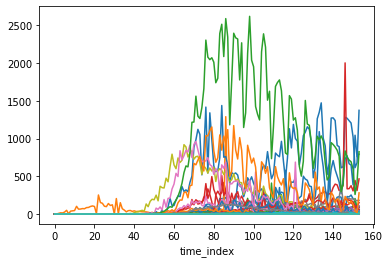

In [34]:
# for groupby later on
multi_deaths_temp = df.set_index(['time_index','location'])
# assuming that the best "deaths" reporting has least number of missing values.
ind = multi_deaths_temp.loc[:, column_search(multi_deaths_temp, 'deaths')].isna().sum().argmin()
# the best column with time, location multiindex. 
deaths_temp = multi_deaths_temp.iloc[:, column_search(multi_deaths_temp, 'deaths', return_style='iloc')[ind]]
deaths_temp.groupby(level=1).diff(1).fillna(0).unstack().plot(legend=False)

my solution: make the cumulative variable actually non-decreasing and then take the finite differences

New deaths is fine coming from ttt but I think even though owid has more missing values, that they are just zeros and so their new cases and new tests normalized should be used. 

owid data is good but populations are bad.



In [35]:
eda_data

,location,date,cases_jhucsse,deaths_jhucsse,recovered_jhucsse,new_tests_testtracker,tests_cumulative_testtracker,tests_per100k_testtracker,source_testtracker,cases_testtracker,...,cvd_death_rate_owid,diabetes_prevalence_owid,female_smokers_owid,male_smokers_owid,handwashing_facilities_owid,hospital_beds_per_thousand_owid,life_expectancy_owid,days_since_first_case,time_index,population_density
0,Afghanistan,2020-01-22,0,0,0,NaN,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0,0,NaN
1,Afghanistan,2020-01-23,0,0,0,NaN,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0,1,NaN
2,Afghanistan,2020-01-24,0,0,0,NaN,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0,2,NaN
3,Afghanistan,2020-01-25,0,0,0,NaN,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0,3,NaN
4,Afghanistan,2020-01-26,0,0,0,NaN,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23095,Zimbabwe,2020-06-19,479,4,63,828.0,61413.0,413.2,https://africacdc.org/covid-19/,479.0,...,307.846,1.82,1.6,30.7,36.791,1.7,61.49,91,149,NaN
23096,Zimbabwe,2020-06-20,479,4,63,515.0,61928.0,416.7,https://africacdc.org/covid-19/,479.0,...,307.846,1.82,1.6,30.7,36.791,1.7,61.49,92,150,NaN
23097,Zimbabwe,2020-06-21,489,6,64,469.0,62397.0,419.8,https://africacdc.org/covid-19/,489.0,...,307.846,1.82,1.6,30.7,36.791,1.7,61.49,93,151,NaN
23098,Zimbabwe,2020-06-22,512,6,64,415.0,62812.0,422.6,https://africacdc.org/covid-19/,512.0,...,307.846,1.82,1.6,30.7,36.791,1.7,61.49,94,152,NaN


In [36]:
eda_data.loc[eda_data.new_cases_owid<0, 'new_cases_owid'] = 0
eda_data.loc[eda_data.new_tests_owid<0, 'new_tests_owid'] = 0
eda_data.loc[eda_data.new_deaths_owid<0, 'new_deaths_owid'] = 0

In [37]:
column_search(eda_data,'death')

Index(['deaths_jhucsse', 'deaths_testtracker', 'deaths_per100k_testtracker',
       'confirmed_deaths_oxcgrt', 'total_deaths_owid', 'new_deaths_owid',
       'total_deaths_per_million_owid', 'new_deaths_per_million_owid',
       'cvd_death_rate_owid'],
      dtype='object')

In [38]:
per_million_population.loc[eda_data.index.intersection(per_million_population.index)]

0        38.928341
1        38.928341
2        38.928341
3        38.928341
4        38.928341
           ...    
23095    14.862927
23096    14.862927
23097    14.862927
23098    14.862927
23099    14.862927
Name: population, Length: 23100, dtype: float64

In [39]:
eda_data.loc[:, 'new_deaths_jhucsse'] = (eda_data.set_index(['time_index','location']).deaths_jhucsse.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)
eda_data.loc[:, 'new_deaths_testtracker'] = (eda_data.set_index(['time_index','location']).deaths_testtracker.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)

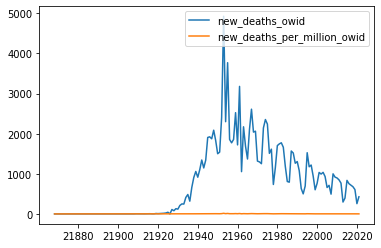

In [40]:
eda_data[eda_data.location=='United States'].loc[:, column_search(eda_data,'new_deaths')[:2]].plot()

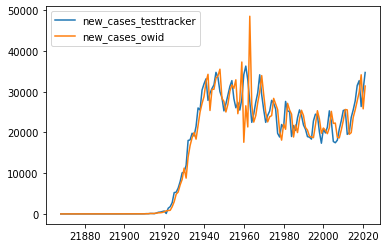

In [41]:
eda_data[eda_data.location=='United States'].loc[:, column_search(eda_data,'new_cases')[:2]].plot()

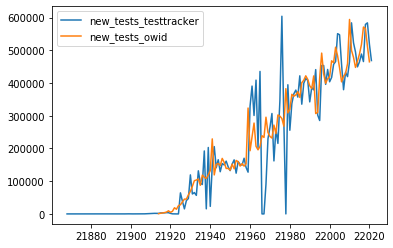

In [42]:
eda_data[eda_data.location=='United States'].loc[:, column_search(eda_data,'new_tests')[:2]].plot()

In [43]:
# Already have a good "new tests" feature, so do not need to compute differences
df.loc[:, 'new_tests_weighted'] = (eda_data.loc[df.index,'new_tests_owid'].fillna(0)/per_million_population).values

# Already have a good "new cases" feature, so do not need to compute differences
df.loc[:, 'new_cases_weighted'] =  (eda_data.loc[df.index,'new_cases_owid'].fillna(0)/per_million_population).values

# Create a number of deaths feature, there are multiple with the same name, hence the reason 'ind' is calculated
# for groupby later on

# # assuming that the best "deaths" reporting has least number of missing values.
# ind = multi_temp.loc[:, column_search(multi_temp, 'deaths')].isna().sum().argmin()
# # the best column with time, location multiindex. 
# deaths_temp = multi_temp.iloc[:, column_search(multi_temp, 'deaths', return_style='iloc')[ind]]
# corrected_deaths_temp = fix_incorrect_decrease(deaths_temp.reset_index(), 'deaths')
# death_values_to_weight = corrected_deaths_temp.set_index(['time_index', 'location']).groupby(level=1).diff(1).fillna(0)#.values
df.loc[:, 'new_deaths_weighted']  =  (eda_data.loc[df.index,'new_deaths_owid'].fillna(0) / per_million_population)

df = fix_incorrect_decrease(df, 'recovered')
df.loc[:, 'new_recovered_weighted'] = (df.set_index(['time_index','location']).recovered.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)

Fixing 0 countries in the recovered column feature


In [44]:
df.loc[:, 'log_new_recovered_weighted'] = df.loc[:, 'new_recovered_weighted'].apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_deaths_weighted']  =  df.loc[:, 'new_deaths_weighted'] .apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_cases_weighted'] =  df.loc[:, 'new_cases_weighted'] .apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_tests_weighted'] = df.loc[:, 'new_tests_weighted'] .apply(lambda x: np.log(x+1))

Better data source seems to be test_tracker for tests and cases. Take recovered from JHUCSSE, tests,cases, and deaths from TestTracker.

For now just look at tests and cases. 

I believe that it is unwarranted to weight these countries with small populations so heavily as they comprise a tiny
fraction of the world population. However, it also seems unfair to divide by area (i.e. to get density) for countries
which have localized pockets of population. 

This next weighting "knows" about the global population and so it couples each country to all other countries.
I don't think this will cause any issues for the CNN in the modeling section but it might. It weights countries by
the percent of the world population which they constitute.

To reiterate my logic: I want or perhaps need to normalize the data. If I normalize simply on a "per million people" basis,
small micro-states such as San Marino will take on disproportionate values. I could drop these countries or look
for other weighting techniques; I opt for the latter method. The other two options I explore are weighting by population density, and weighting by the percentage of the world's population that each country comprises. The goal is to find a normalization which captures how hard individual countries have been hit but also the possible future downside, which
is of course is dependent upon how many people live in a country.

Also, the time-series of countries which have caught more cases overall will likely have better reporting practices and
be closer to the actual behavior of the virus transmission. Visual inspection of certain time series leads me to believe
they will simply act as noise, obfuscating the average or "actual" behavior. 

The current per capita weighting gives undue influence to microstate nations such as San Marino, as their population is
only a small fraction of 1 million. Therefore, remove the countries in the bottom 10 percent (arbitrary) of populations. 

Now that the new features with which to model are in place, remove the redundant and useless infomation.

Do I want to keep cumulative variables now that they are fixed???

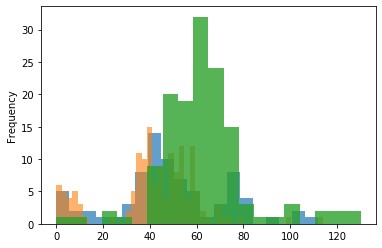

In [45]:
first_dates_temp = df.replace(to_replace=0., value=np.nan)
first_tests = df.loc[first_dates_temp.total_tests.dropna().index,:].groupby('location').time_index.min()
first_cases =  df.loc[first_dates_temp.total_cases.dropna().index,:].groupby('location').time_index.min()
first_deaths = df.loc[first_dates_temp.total_deaths.dropna().index,:].groupby('location').time_index.min()
first_tests.plot.hist(alpha=0.7, bins=20)
first_cases.plot.hist(alpha=0.6, bins=50)
first_deaths.plot.hist(alpha=0.8, bins=20)


In [46]:
df_pruned = df.drop(columns=(redundant_death_columns.tolist() 
                         + redundant_test_columns.tolist() 
                         + redundant_case_columns.tolist()+['recovered']))

In [47]:
assumed_to_be_better_stringency_index = df_pruned.loc[:, 'stringency_index'].isna().sum().argmin()
stringency = df_pruned.loc[:, 'stringency_index'].iloc[:, assumed_to_be_better_stringency_index]

df_pruned = df_pruned.drop(columns=['country_name', 'country_code',
                                                    'm1_wildcard','stringency_index_for_display',
                                                   'stringency_legacy_index', 'stringency_legacy_index_for_display',
                                                    'government_response_index_for_display',
                                                    'containment_health_index_for_display',
                                                    'economic_support_index_for_display',
                                                    'iso_code','stringency_index'])
df_pruned.loc[:, 'stringency_index'] = stringency.values

Personal preference of reordered the DataFrame; also helps with different missing value strategies later.

In [48]:
indexers = ['location','date','time_index','days_since_first_case']
new_weighted_quantity_features = ['new_cases_weighted',
            'new_tests_weighted', 
            'new_recovered_weighted', 
            'new_deaths_weighted']
log_new_weighted_quantity_features = ['log_new_cases_weighted',
            'log_new_tests_weighted', 
            'log_new_recovered_weighted', 
            'log_new_deaths_weighted']
flag_features = column_search(df_pruned,'flag')
time_independent_features =df_pruned.loc[:, 'population':'hospital_beds_per_thousand'].columns.tolist()
time_dependent_features = df_pruned.loc[:, 'c1_school_closing':'economic_support_index'].columns.difference(flag_features).tolist()+['stringency_index']
flag_features = flag_features.tolist()+['tests_units']

The flag columns take values 1.0, 0.0, np.nan. 
Convert these to categorical, and for the sake of column names map floats to str.
Afterwards, drop the column that corresponds to missing values to remove collinearity. 

In [50]:
df_reorder = df_pruned.loc[:, indexers
                              +log_new_weighted_quantity_features
                              +new_weighted_quantity_features
                              +time_dependent_features
                              +time_independent_features
                              +flag_features]

flag_df = df_reorder.loc[:, flag_features].fillna('Missing').astype('category')
for col in flag_df.columns:
    flag_df.loc[:, col] = flag_df.loc[:, col].cat.rename_categories({1.0 : '1', 0. : '0'})
    
flag_dummies = pd.get_dummies(flag_df)
flag_dummies_without_collinearity = flag_dummies[flag_dummies.columns[~flag_dummies.columns.str.contains('Missing')]]
df_reorder = pd.concat((df_reorder.drop(columns=flag_features),
                        flag_dummies_without_collinearity),axis=1)

missing_flags = df_reorder.iloc[:,np.where(df_reorder.isna().sum() > 0)[0]].isna().astype(int)
missing_flags.columns = missing_flags.columns + '_missing_flag'

for country_indices in country_groupby(df_reorder):
    fill_tmp = df_reorder.loc[country_indices, time_independent_features].fillna(method='ffill').fillna(method='bfill')
    df_reorder.loc[country_indices, time_independent_features] = fill_tmp.values
    df_reorder.loc[country_indices, time_dependent_features] = df_reorder.loc[country_indices, time_dependent_features].fillna(method='ffill').fillna(value=0)
df_reorder.loc[:, time_independent_features] = df_reorder.loc[:, time_independent_features].fillna(df_reorder.loc[:, time_independent_features].median())
df = regularize_names(df_reorder).copy()

location_dummies_without_collinearity = pd.get_dummies(df.location, drop_first=True)
location_dummies_without_collinearity.columns += '_flag'
location_dummies_without_collinearity = regularize_names(location_dummies_without_collinearity)

In [ ]:
# # for country_indices in country_groupby(df_reorder):
# df_reorder.loc[:, time_independent_features] = df_reorder.set_index(['time_index', 'location']).loc[:, time_independent_features].fillna(method='ffill').fillna(method='bfill')
# df_reorder.loc[:, time_dependent_features] = df_reorder.loc[:, time_dependent_features].fillna(method='ffill').fillna(value=0)
# # If I want to use the features which are still missing values, need to do something; including zeros seems wrong. 
# df_reorder.loc[:, time_independent_features] = df_reorder.loc[:, time_independent_features].fillna(df_reorder.loc[:, time_independent_features].median())
# df_reorder = regularize_names(df_reorder)
# df = df_reorder.copy()

Because I'm going to impute values for the time independent features, it may or may not be important to track this by flagging
the missing values via one-hot encoding. Note that I have just manipulated the flagging columns so that *their* missing value flags are not included; but again this is because of linear dependency reasons. 

For time independent features, do not have to be careful with time; because there is no two-sided fillna method that
I am aware of, handle this by filling forwards and backwards.

Time dependent features can only be filled forward so that information from the future is not visible from the past. Additionally, any other missing values are filled with 0's; only other options would be, for instance, the mean up to that date. 

# Feature production

In [54]:
# Majority 
# time_dependent_features = list(np.array(time_dependent_features)[(df.loc[:, time_dependent_features].nunique() > 10).values])
# time_dependent_features

In [55]:
oxcgrt_index_variables = df.loc[:,column_search(df,'index')].columns[1:].intersection(
                   pd.Index(time_dependent_features)).tolist()

In [56]:
all_df = df.loc[:, indexers 
                  + log_new_weighted_quantity_features
                  + new_weighted_quantity_features 
                  + time_dependent_features
                  + time_independent_features
                 ].copy()

all_df = pd.concat((all_df, location_dummies_without_collinearity, missing_flags),axis=1)


In [57]:
# use multiples of 7 to capture weekly seasonality
roll_widths = [7,14,21,28]

new_features_list = rolling_means(all_df, 
                                  new_weighted_quantity_features
                                  +time_dependent_features, 
                                  roll_widths=roll_widths)
new_features = pd.concat(new_features_list, axis=1)

export_to_modeling = pd.concat((all_df,
                                new_features
                               ),axis=1)
export_to_modeling.to_csv('regression_data.csv')

In [59]:

new_features_list = rolling_means(all_df, log_new_weighted_quantity_features+new_weighted_quantity_features, roll_widths=[3])
new_features = pd.concat(new_features_list, axis=1)
# tmp = new_features.iloc[:,[0,1,2,3,-1,-7,-8,-13]]
# tmp.columns = [x[0] for x in tmp.columns.str.split('_rolling_mean_3')]
cnn_features =  (indexers 
#                 + log_new_weighted_quantity_features
                +new_weighted_quantity_features 
#                 + df.loc[:,column_search(df,'index')].columns[1:].tolist()
#                 +oxcgrt_index_variables
                )
               
cnn_df = all_df.loc[:, cnn_features]
cnn_df.to_csv('cnn_data.csv')

In [64]:
# changing the values to better respect 

df_pruned_numerical = df_pruned.copy()
df_tmp = df_pruned_numerical.loc[:, new_weighted_quantity_features].replace(to_replace=0., value=np.nan)
for country_indices in country_groupby(df_pruned_numerical):
    df_tmp.loc[country_indices, :] = df_tmp.loc[country_indices, :].fillna(method='ffill').fillna(value=0)
df_pruned_numerical.loc[:, new_weighted_quantity_features] = df_tmp.values

df_reorder_numerical = df_pruned_numerical.loc[:, indexers
                              +new_weighted_quantity_features
                                          ]

In [66]:
df_numerical= regularize_names(df_reorder_numerical).copy()

In [74]:
roll_widths = [7,14,21,28]

regression_df = df_numerical.loc[:, indexers 
                 + new_weighted_quantity_features 
                      ].copy()

new_features_list = rolling_features(regression_df, 
                                  new_weighted_quantity_features,
                                  roll_widths=roll_widths)

export_to_modeling = pd.concat((regression_df,
                                new_features_list,
                               ),axis=1)

In [75]:
export_to_modeling.to_csv('regression_data_numerical.csv')

# Introduction <a id='intro'></a>

This notebook uses a variety of different COVID-19 related datasets to explore the behavior
of the multiple time series'. This notebook also creates new features that attempt to encapsulate the
time dependent (and time delayed) nature of the problem; these will be used during the model creation
project which makes time dependent forecasting models. 


## Exploratory Data Analysis<a id='EDA'></a>
Ideas for the inclusion or creation of new columns.

Moving averages
fourier
signal
flags for lots of different things

MI vs GA

hardest hit countries

days since

which dataset it came from

distribution of initial tests, responses, cases dates.

humans view, interpret and forecast things in a way which are not available to robots. 
data driven, time dependent manner of modeling. Really trying to encapsulate the time dependence. 

I'm electing to fill the time independent features which are ***still*** missing with the median of ***all*** current values; otherwise I would have to drop them because of the missing values. This is ok? perhaps? It's hard to justify. 

Because the features I will be predicting are all measured per million people, it seems unwise to include
very small countries and microstates such as San Marino; whose small population makes them has the maximum 
value in all quantities measured "per million". In other words, I want to normalize by population but the
dynamics of these small states seems to be fundamentally different due to size.

In [76]:
usa_time_series_df.reset_index().set_index(['date', 'location']).groupby(level=1).diff(1).fillna(0).unstack().iloc[-1,:].sort_values()

csse_us_timeseries  location                
confirmed           Idaho                         -2.0
deaths              Oregon                         0.0
                    Northern Mariana Islands       0.0
                    Nevada                         0.0
                    Montana                        0.0
                                                 ...  
confirmed           Georgia                     1882.0
                    Florida                     3286.0
                    Arizona                     3779.0
                    Texas                       5142.0
                    California                  6712.0
Name: 2020-06-23 00:00:00, Length: 116, dtype: float64

In [77]:
all_df.loc[all_df.days_since_first_case.replace(to_replace=[0,0.], value=np.nan).dropna().index,:]

,location,date,time_index,days_since_first_case,log_new_cases_weighted,log_new_tests_weighted,log_new_recovered_weighted,log_new_deaths_weighted,new_cases_weighted,new_tests_weighted,...,aged_65_older_missing_flag,aged_70_older_missing_flag,gdp_per_capita_missing_flag,extreme_poverty_missing_flag,cvd_death_rate_missing_flag,diabetes_prevalence_missing_flag,female_smokers_missing_flag,male_smokers_missing_flag,handwashing_facilities_missing_flag,hospital_beds_per_thousand_missing_flag
34,Afghanistan,2020-02-25,34,1,0.025364,0.000000,0.000000,0.000000,0.025688,0.000000,...,0,0,0,1,0,0,1,1,0,0
35,Afghanistan,2020-02-26,35,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,1,1,0,0
36,Afghanistan,2020-02-27,36,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,1,1,0,0
37,Afghanistan,2020-02-28,37,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,1,1,0,0
38,Afghanistan,2020-02-29,38,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23095,Zimbabwe,2020-06-19,149,91,1.643154,3.059599,0.000000,0.000000,4.171453,20.319013,...,0,0,0,0,0,0,0,0,0,0
23096,Zimbabwe,2020-06-20,150,92,0.730686,3.155809,0.000000,0.000000,1.076504,22.472020,...,0,0,0,0,0,0,0,0,0,0
23097,Zimbabwe,2020-06-21,151,93,0.385922,3.343437,0.065115,0.126248,0.470970,27.316288,...,0,0,0,0,0,0,0,0,0,0
23098,Zimbabwe,2020-06-22,152,94,0.183857,0.000000,0.000000,0.000000,0.201844,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [78]:
first_30_days = all_df[(all_df.days_since_first_case>0) & (all_df.days_since_first_case<30)].set_index(['location', 'date']).index
max_response_level30 = oxcgrt_df.loc[first_30_days,:].groupby(level=0).max()
mean_response_level30 = oxcgrt_df.loc[first_30_days,:].groupby(level=0).mean()


In [79]:
# pd.MultiIndex.from_tuples(idxmaxes.days_since_first_case.values)

In [80]:
all_df[(all_df.days_since_first_case>0) & (all_df.days_since_first_case<30)].set_index(['location', 'date']).reset_index(level=1).groupby(level=0).date.max()

location
Afghanistan   2020-03-24
Albania       2020-04-07
Algeria       2020-03-25
Andorra       2020-03-31
Angola        2020-04-18
                 ...    
Venezuela     2020-04-12
Vietnam       2020-02-21
Yemen         2020-05-09
Zambia        2020-04-16
Zimbabwe      2020-04-18
Name: date, Length: 150, dtype: datetime64[ns]

In [81]:
csse_global_time_series_df

cases  deaths  recovered
location    date                                
Afghanistan 2020-01-22      0       0          0
            2020-01-23      0       0          0
            2020-01-24      0       0          0
            2020-01-25      0       0          0
            2020-01-26      0       0          0
...                       ...     ...        ...
Zimbabwe    2020-06-19    479       4         63
            2020-06-20    479       4         63
            2020-06-21    489       6         64
            2020-06-22    512       6         64
            2020-06-23    525       6         64

[28798 rows x 3 columns]

In [82]:
idxmaxes = all_df[(all_df.days_since_first_case>0) & (all_df.days_since_first_case<=30)].set_index(['location', 'date']).groupby(level=0).idxmax()
cases_30_days_after = csse_global_time_series_df.loc[all_df.set_index(['location', 'date']).loc[idxmaxes.days_since_first_case.values].index,'cases']
cases_60_days_after = csse_global_time_series_df.loc[all_df.set_index(['location', 'date']).loc[idxmaxes.days_since_first_case.values].index,'cases']

In [83]:
thirty_days_after_max_stringency = all_df[(all_df.days_since_first_case>0) & (all_df.days_since_first_case<=30)].groupby('location').max().stringency_index
thirty_days_after_mean_stringency = all_df[(all_df.days_since_first_case>0) & (all_df.days_since_first_case<=30)].groupby('location').mean().stringency_index
thirty_days_after_cases_total = csse_global_time_series_df.loc[all_df[all_df.days_since_first_case==30].set_index(['location', 'date']).index].cases
sixty_days_after_cases_total = csse_global_time_series_df.loc[all_df[all_df.days_since_first_case==60].set_index(['location', 'date']).index].cases

In [84]:
sixty_days_after_cases_total.index.get_level_values(0)

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       ...
       'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay',
       'Uzbekistan', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='location', length=148)

In [85]:
sixty_days_after_cases_total.values

array([  1351,    850,   3256,    745,     52,   4681,   2810,  15148,
         1804,   2518,  12425,     86,  12208,  18431,     18,    339,
            7,   2556,   1926,     35,  63100,    141,   1829,    748,
           63,     99,   2104,   4042,    143,    519,  18435,  81435,
         8613,    755,   2016,   1783,    891,   7682,   8896,   1401,
           16,   6972,  24934,   2350,   1413,     39,   1647,    261,
           18,   1240,  22622,   1004,    486,  50871,   5408,   2517,
         1342,   3118,    109,    533,   1972,   2998,   1795,   1251,
        10551,   1708,  20253,  13942, 105792,   1700,    502,   1101,
          460,   5279,    715,   1038,   2614,    870,    677,    219,
           75,   1344,   3769,    326,    336,   1796,   1030,     15,
          332,  16752,     42,   4569,    162,     16,      3,  38440,
         1474,     25,    914,   1532,   7527,   1790,  13328,   8282,
            8,    462,  51189,   1546,  13693,  25351,  12564,  11036,
      

In [86]:
thirty_days_after_max_stringency.values

array([ 59.26,  84.26,  75.  ,  48.15,  90.74, 100.  ,  19.44,  85.19,
        88.89,  69.44,  87.04,  88.89,   8.33,  13.89,  63.89,  70.83,
        77.78,  96.3 ,  89.81,  86.11,  74.54,  52.78,  73.15,  84.26,
        22.22,   0.  ,  68.52,   2.78,  68.52,  88.89,  73.15,  77.31,
        87.96,  75.  ,  96.3 ,  73.15,  92.59,  82.41,  72.22,  94.44,
        85.19,  89.81,  93.52,  11.11,  88.89,  93.52,  72.22,  80.56,
        88.89,  19.44,  13.89,  78.7 ,  90.74,  16.67,  86.11,  84.26,
        93.52,  78.7 ,  87.04,  87.04, 100.  ,  76.85,  53.7 ,  10.19,
        50.93,  94.44,  85.19,  81.48,  69.91,  80.56,  78.7 ,  25.  ,
       100.  ,  89.35,  91.67,  92.59,  81.48,  65.74,  85.19,  62.04,
        87.96, 100.  ,  81.48,  79.63,  95.37,  57.41,  19.44,  72.22,
        77.78,  82.41,  63.89,  65.74,  93.52,  56.48,  66.67,  16.67,
        74.07,  96.3 ,  16.67,  61.11,  82.87,  75.93,  81.48,  96.3 ,
        90.74,  80.56,  93.52,  94.44,  25.  ,  81.48,  82.41,  86.11,
      

In [87]:
thirty_days_after_mean_stringency.values

array([30.61866667, 79.56766667, 25.46433333, 23.95066667, 77.036     ,
       58.98166667, 17.40366667, 43.952     , 50.773     , 40.37333333,
       62.501     , 71.48166667,  4.44266667, 11.29533333, 61.42066667,
       52.175     , 48.333     , 82.872     , 67.435     , 84.44333333,
       36.08033333, 49.168     , 62.37866667, 62.469     , 19.537     ,
        0.        , 37.56366667,  2.78      , 49.38333333, 42.037     ,
       38.67333333, 71.94266667, 57.314     , 56.29766667, 38.05666667,
       50.61966667, 69.87433333, 58.796     , 47.90033333, 86.72433333,
       67.87433333, 44.90533333, 55.74033333,  0.37033333, 88.11833333,
       82.87133333, 27.592     , 54.84866667, 86.32766667, 12.31633333,
       13.334     , 63.95166667, 52.99466667,  8.52033333, 67.40733333,
       46.634     , 88.73533333, 52.09766667, 56.36066667, 79.91      ,
       89.41333333, 56.69533333, 33.859     , 10.19      , 42.379     ,
       67.99366667, 38.581     , 41.23233333, 33.76333333, 62.75

In [88]:
thirty_days_after_cases_total.values

array([   84,   400,   367,   390,    24,  1133,    15,  6909,   298,
         419,   164,    75,    94,    50,    18,    35,     5,   268,
         624,    23,  3417,   135,   577,   443,    11,     1,   650,
          11,    11,    33,  3404, 75550,  1485,   454,   495,   620,
         526,  3308,  2366,   732,    16,  1109,  2240,   110,   190,
          39,   645,    71,    17,     2,    12,    57,    83,    27,
         566,   966,   156,   288,    45,    47,   382,   623,  1020,
           3,  1677,   346,  2910,   883,  1694,   444,    63,   105,
         299,   951,   197,   731,   195,   446,   248,     4,    59,
          60,   460,  1988,   121,    38,    22,   325,     7,   324,
         993,    16,   654,    39,    16,     1,  9819,   514,     9,
         648,   111,  3755,    99,  1373,  2528,     7,   115,  2281,
           3,  3383,  8251,   693,  1292,     2,   127,   224,  1720,
         190,  1908,    11,   124,    85,   977,    80,  1585,    52,
         120,     1,

9.777277823376707e-11


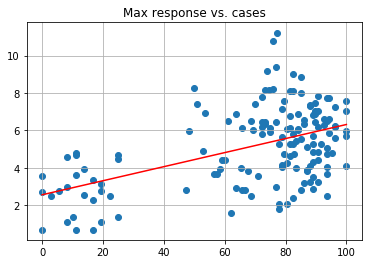

In [89]:
y= np.log(thirty_days_after_cases_total.values+1)
x = thirty_days_after_max_stringency.values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Max response vs. cases')
ax.grid(True)
print(p_value)

0.001272874040621854


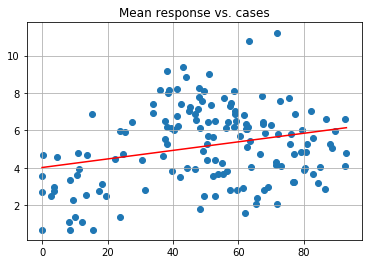

In [90]:
y= np.log(thirty_days_after_cases_total.values+1)
# y = thirty_days_after_cases_total.values
x = thirty_days_after_mean_stringency.values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Mean response vs. cases')
ax.grid(True)
print(p_value)

In [91]:
countries_with_sixty = sixty_days_after_cases_total.index.get_level_values(0)
thirty_days_after_cases_total.loc[countries_with_sixty]
thirty_days_after_max_stringency.loc[countries_with_sixty]
thirty_days_after_mean_stringency.loc[countries_with_sixty]

location
Afghanistan    30.618667
Albania        79.567667
Algeria        25.464333
Andorra        23.950667
Angola         77.036000
                 ...    
Venezuela      80.959000
Vietnam        31.357667
Yemen          46.634667
Zambia         44.213667
Zimbabwe       76.788333
Name: stringency_index, Length: 148, dtype: float64

0.6270178066579544


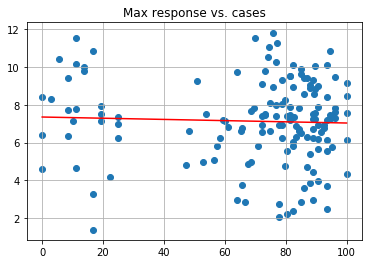

In [92]:
y= np.log((sixty_days_after_cases_total.values)+1)
x = thirty_days_after_max_stringency.loc[countries_with_sixty].values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Max response vs. cases')
ax.grid(True)
print(p_value)

0.004752234992026396


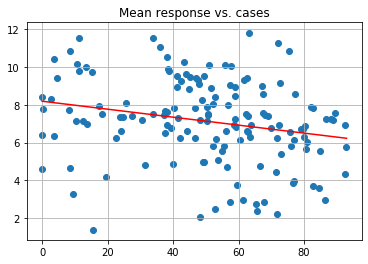

In [93]:
y= np.log((sixty_days_after_cases_total.values)+1)
x = thirty_days_after_mean_stringency.loc[countries_with_sixty].values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Mean response vs. cases')
ax.grid(True)
print(p_value)

0.20772473863493235


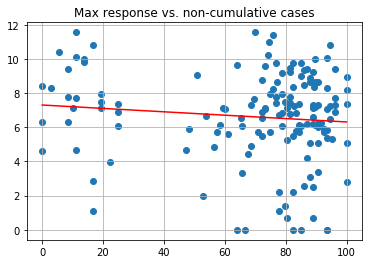

In [94]:
y= np.log((sixty_days_after_cases_total.values-thirty_days_after_cases_total.loc[countries_with_sixty].values)+1)
x = thirty_days_after_max_stringency.loc[countries_with_sixty].values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Max response vs. non-cumulative cases')
ax.grid(True)
print(p_value)

0.000234812755159549


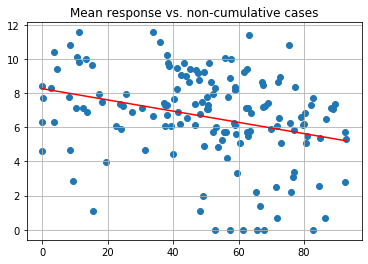

In [95]:
y= np.log((sixty_days_after_cases_total.values-thirty_days_after_cases_total.loc[countries_with_sixty].values)+1)
x = thirty_days_after_mean_stringency.loc[countries_with_sixty].values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Mean response vs. non-cumulative cases')
ax.grid(True)
print(p_value)

In [96]:
cases_after_total = csse_global_time_series_df.loc[all_df[all_df.days_since_first_case==60].set_index(['location', 'date']).index].cases

In [97]:
countries_with_sixty = sixty_days_after_cases_total.index.get_level_values(0)
thirty_days_after_cases_total.loc[countries_with_sixty]
thirty_days_after_max_stringency.loc[countries_with_sixty]
thirty_days_after_mean_stringency.loc[countries_with_sixty]

location
Afghanistan    30.618667
Albania        79.567667
Algeria        25.464333
Andorra        23.950667
Angola         77.036000
                 ...    
Venezuela      80.959000
Vietnam        31.357667
Yemen          46.634667
Zambia         44.213667
Zimbabwe       76.788333
Name: stringency_index, Length: 148, dtype: float64

0.000234812755159549


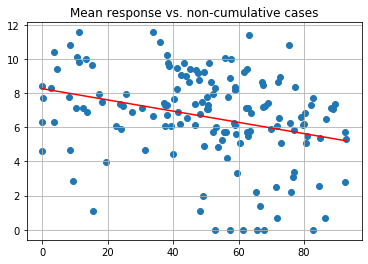

In [98]:
y= np.log((sixty_days_after_cases_total.values-thirty_days_after_cases_total.loc[countries_with_sixty].values)+1)
x = thirty_days_after_mean_stringency.loc[countries_with_sixty].values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Mean response vs. non-cumulative cases')
ax.grid(True)
print(p_value)

In [99]:
max_response_levels = oxcgrt_df.stringency_index.groupby(level=0).max()
mean_response_levels = oxcgrt_df.stringency_index.groupby(level=0).mean()

In [100]:
(first_30_days.get_level_values(0).unique().unique(),first_30_days.get_level_values(1).max())

(Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina',
        'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
        ...
        'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay',
        'Uzbekistan', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe'],
       dtype='object', name='location', length=150),
 Timestamp('2020-06-11 00:00:00'))

In [101]:
csse_global_time_series_df.loc[(first_30_days.get_level_values(0).unique().unique(),first_30_days.get_level_values(1).max()),:]

,,cases,deaths,recovered
location,date,,,
Afghanistan,2020-06-11,22890,426,3326
Albania,2020-06-11,1385,35,1001
Algeria,2020-06-11,10589,741,7255
Andorra,2020-06-11,852,51,780
Angola,2020-06-11,118,5,41
...,...,...,...,...
Venezuela,2020-06-11,2814,23,487
Vietnam,2020-06-11,332,0,321
Yemen,2020-06-11,591,136,23


In [102]:
csse_global_time_series_df.loc[pd.IndexSlice[:, csse_global_time_series_df.reset_index().date.max()],:]

,,cases,deaths,recovered
location,date,,,
Afghanistan,2020-06-23,29481,618,9260
Albania,2020-06-23,2047,45,1195
Algeria,2020-06-23,12076,861,8674
Andorra,2020-06-23,855,52,797
Angola,2020-06-23,189,10,77
...,...,...,...,...
West Bank And Gaza,2020-06-23,1169,3,442
Western Sahara,2020-06-23,10,1,8
Yemen,2020-06-23,992,261,356


In [103]:
from scipy.stats import percentileofscore

In [104]:
oxcgrt_df.stringency_index.groupby(level=0).mean().sort_values().values

array([ 7.41772455,  7.86728324, 12.88310345, 22.7708805 , 22.82173653,
       24.01429412, 24.07425287, 24.71798851, 25.05030488, 25.8983815 ,
       27.02541176, 27.0704023 , 27.82053892, 29.50607362, 30.23156627,
       30.4227907 , 30.77945783, 31.29309524, 31.74814103, 33.00512048,
       33.16370588, 33.5091411 , 33.99676136, 34.20952096, 34.2225    ,
       34.62865031, 34.64149701, 35.37936416, 35.45      , 36.29632184,
       36.32814371, 36.43560241, 36.57628743, 36.71052941, 36.78892857,
       37.00586207, 37.16563218, 37.46561728, 37.75040462, 37.86534483,
       37.95290909, 38.05850575, 38.41213873, 38.45754601, 38.49651163,
       38.57402439, 38.81329412, 38.83557471, 39.42284848, 39.51761006,
       39.52564417, 39.56932515, 39.75604651, 39.84301205, 40.03109091,
       40.10359281, 40.1058046 , 40.29537572, 40.43652941, 40.84352941,
       40.92988235, 41.37745665, 41.58299401, 41.61788571, 41.70454545,
       41.85182353, 41.86147059, 42.00754386, 42.26115607, 42.28

In [105]:
oxcgrt_df.stringency_index.groupby(level=0).mean().sort_values().loc['United States']

42.32795180722883

In [106]:
percentileofscore(oxcgrt_df.stringency_index.groupby(level=0).mean().sort_values().values,oxcgrt_df.stringency_index.groupby(level=0).mean().sort_values().loc['United States'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1942: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1943: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)


40.449438202247194

In [107]:
oxcgrt_df.stringency_index.groupby(level=0).mean().sort_values().loc['United States']

42.32795180722883

In [108]:
oxcgrt_df.stringency_index[oxcgrt_df.stringency_index==100].index.get_level_values(0).unique()

Index(['Argentina', 'Cuba', 'Djibouti', 'Georgia', 'Honduras', 'India',
       'Jordan', 'Kuwait', 'Libya', 'Sri Lanka', 'Philippines', 'El Salvador',
       'Serbia'],
      dtype='object', name='location')

In [109]:
todays_cases = csse_global_time_series_df.loc[pd.IndexSlice[:, csse_global_time_series_df.reset_index().date.max()],:]#.loc[max_response_levels.index,:].cases

In [110]:
intersection = max_response_levels.index.intersection(todays_cases.droplevel(level=1).index)

In [111]:
todays_cases = todays_cases.loc[intersection,:]
max_response_levels = max_response_levels.loc[intersection]
mean_response_levels = mean_response_levels.loc[intersection]

0.0034598179329164967


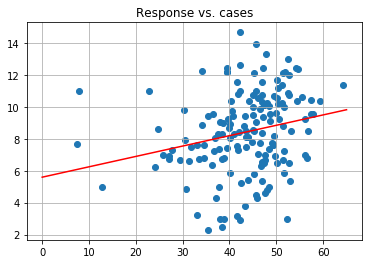

In [112]:
y= np.log(todays_cases.cases.values+1)
x = mean_response_levels.values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Response vs. cases')
ax.grid(True)
print(p_value)

0.5340732315475132


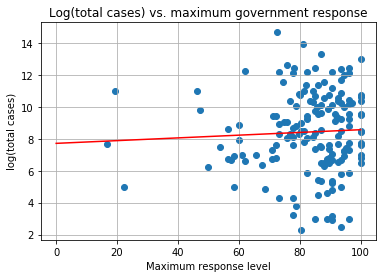

In [113]:
y= np.log(todays_cases.cases.values+1)
x = max_response_levels.values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Log(total cases) vs. maximum government response')
ax.set_ylabel('log(total cases)')
ax.set_xlabel('Maximum response level')
ax.grid(True)
print(p_value)

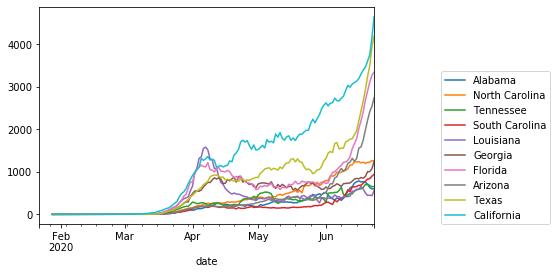

In [114]:
new_cases_states =  usa_time_series_df.reset_index().set_index(['date', 'location']).groupby(level=1).diff(1).fillna(0)
ten_states_with_most_new_cases_06222020 = new_cases_states.confirmed.unstack().iloc[-1,:].sort_values()[-10:].index

new_cases_states.confirmed.unstack().loc[:, ten_states_with_most_new_cases_06222020].rolling(7).mean().plot()
plt.legend(loc=(1.2,0))

In [115]:
hospitalization = pd.read_csv('./ihme/Hospitalization_all_locs.csv', index_col=0)
hospitalization

,location_name,date,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,InvVen_lower,...,totdea_lower_smoothed,totdea_upper_smoothed,mobility_data_type,mobility_composite,total_tests_data_type,total_tests,confirmed_infections,est_infections_mean,est_infections_lower,est_infections_upper
V1,,,,,,,,,,,,,,,,,,,,,
1,Abruzzo,2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
2,Abruzzo,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
3,Abruzzo,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
4,Abruzzo,2020-02-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,observed,0.0,0.0,0.0,0.0,0.0
5,Abruzzo,2020-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,observed,6.127576,observed,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52295,Zacatecas,2020-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52296,Zacatecas,2020-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52297,Zacatecas,2020-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
summary_stats = pd.read_csv('./ihme/Summary_stats_all_locs.csv', index_col=0)
summary_stats.columns

Index(['peak_bed_day_mean', 'peak_bed_day_lower', 'peak_bed_day_upper',
       'peak_icu_bed_day_mean', 'peak_icu_bed_day_lower',
       'peak_icu_bed_day_upper', 'peak_vent_day_mean', 'peak_vent_day_lower',
       'peak_vent_day_upper', 'all_bed_capacity', 'icu_bed_capacity',
       'all_bed_usage', 'icu_bed_usage', 'available_all_nbr',
       'available_icu_nbr', 'travel_limit_start_date', 'travel_limit_end_date',
       'stay_home_start_date', 'stay_home_end_date',
       'educational_fac_start_date', 'educational_fac_end_date',
       'any_gathering_restrict_start_date', 'any_gathering_restrict_end_date',
       'any_business_start_date', 'any_business_end_date',
       'all_non-ess_business_start_date', 'all_non-ess_business_end_date'],
      dtype='object')

In [117]:
pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Florida')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date

In [118]:
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

NameError: name 'roll_width' is not defined

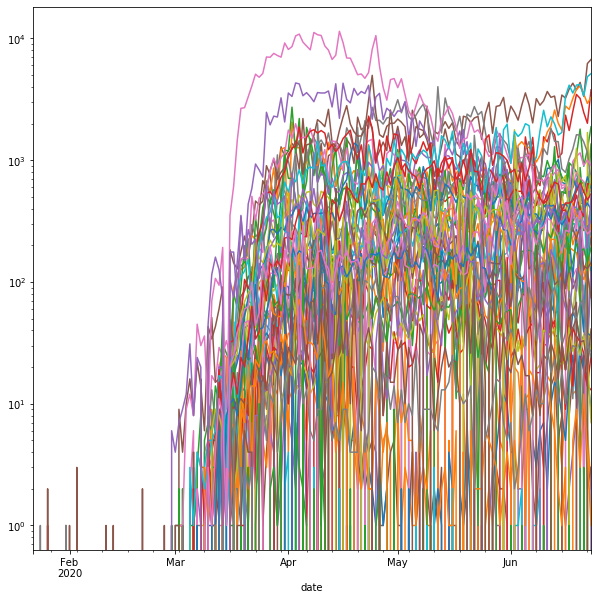

In [119]:
usa_time_series_df.reset_index().set_index(['date', 'location']).groupby(level=1).diff(1).fillna(0).confirmed.unstack().plot(legend=False, figsize=(10,10))
plt.yscale('log')

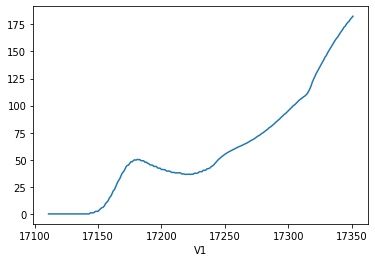

In [120]:
hospitalization[hospitalization.location_name=='Georgia'].newICU_mean.plot()

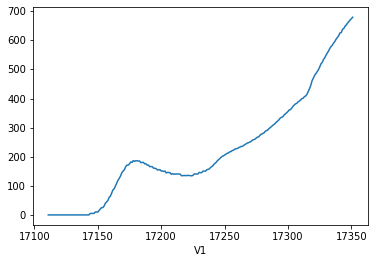

In [121]:
hospitalization[hospitalization.location_name=='Georgia'].admis_mean.plot()

In [122]:

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds

csse_us_timeseries,location,date,confirmed,deaths
1848,Georgia,2020-01-22,0,0
1849,Georgia,2020-01-23,0,0
1850,Georgia,2020-01-24,0,0
1851,Georgia,2020-01-25,0,0
1852,Georgia,2020-01-26,0,0
...,...,...,...,...
1997,Georgia,2020-06-19,62009,2636
1998,Georgia,2020-06-20,63809,2642
1999,Georgia,2020-06-21,64701,2643
2000,Georgia,2020-06-22,65928,2648


NameError: name 'roll_width' is not defined

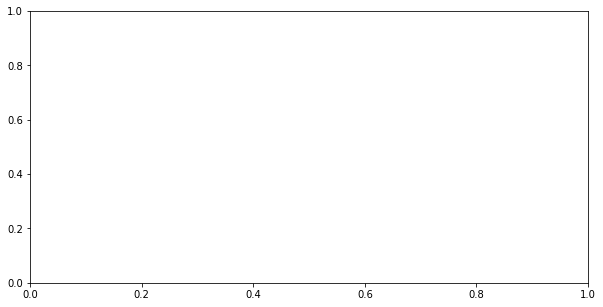

In [123]:
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Florida')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').deaths.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.2, label='+- 7-day STD Florida')
ax.plot(range(len(pds)), rollmean, color='b', label='7-day MA Florida')

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').deaths.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.2, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean, color='orange', linestyle='-.',label='7-day MA Georgia')

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Michigan')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').deaths.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.2, label='+- 7-day STD Michigan')
ax.plot(range(len(pds)), rollmean, color='g',linestyle='--', label='7-day MA Michigan')

plt.legend(loc=(0.01,0.5))
plt.title('Daily new cases comparison, GA vs. MI')
_ = ax.set_ylabel('New deaths')
_ = ax.set_xlabel('Date')
_ = ax.set_xticks(list(range(0,153,30)))
_ = ax.set_xticklabels(pds.index[::30])
ax.grid(True)
plt.savefig('GAvsMIcases.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.2, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean,linestyle='-.',label='7-day MA Georgia')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Florida')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.2, label='+- 7-day STD Florida')
ax.plot(range(len(pds)), rollmean, color='b', label='7-day MA Florida')

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.2, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean, color='orange', linestyle='-.',label='7-day MA Georgia')

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Michigan')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.2, label='+- 7-day STD Michigan')
ax.plot(range(len(pds)), rollmean, color='g',linestyle='--', label='7-day MA Michigan')

plt.legend(loc=(0.01,0.5))
plt.title('Daily new cases comparison, GA vs. MI')
_ = ax.set_ylabel('New cases')
_ = ax.set_xlabel('Date')
_ = ax.set_xticks(list(range(0,153,30)))
_ = ax.set_xticklabels(pds.index[::30])
ax.grid(True)
plt.savefig('GAvsMIcases.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean, color='k', label='7-day MA Georgia')

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Michigan')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Michigan')
ax.plot(range(len(pds)), rollmean, color='k',linestyle='--', label='7-day MA Michigan')

plt.legend(loc=(0.01,0.7))
plt.title('Daily new cases comparison, GA vs. MI')
_ = ax.set_ylabel('Daily Deaths')
_ = ax.set_xlabel('Date')
_ = ax.set_xticks([0, 50,100])
_ = ax.set_xticklabels(pds.index[::50])
plt.savefig('GAvsMIcases.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')].iloc[-100:]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean()#.values.ravel()#.fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std()#values.ravel()#.fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean, color='k', label='7-day MA Georgia')

plt.legend(loc=(0.01,0.7))
plt.title('Daily new cases comparison GA')
_ = ax.set_ylabel('Daily Deaths')
_ = ax.set_xlabel('Date')
_ = ax.set_xticks(list(range(0, 101, 15)))
_ = ax.set_xticklabels(pds.index[-100::15])


In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
eda_data.groupby('date').mean().stringency_index_oxcgrt.plot(ax=ax, label='Stringency index')
eda_data.groupby('date').new_cases_owid.mean().plot(ax=ax2, color='r', label='New cases')
ax.set_ylim([0,100])
ax.set_title('Average global stringency')
ax.set_ylabel('Stringency index from OxCGRT')
ax2.set_ylabel('Global average of new cases')
ax.legend(loc=(0,0.9))
ax2.legend(loc=(0,0.8))

Is this decrease warranted? to confirm, look at the average global rate of new cases.

In [124]:
growth_rates = []
past3days = df[df.time_index >= df.time_index.max()-2]
for c in country_groupby(df):
    growth_rates.append(past3days.loc[c.intersection(past3days.index),:].new_cases_weighted.diff(1).diff(1).dropna().values[0])
growth_rates = np.array(growth_rates)
growth_rates[np.abs(growth_rates)<10**-4] = 0

In [125]:
positive_growth = 100 * (growth_rates> 0).sum() / len(growth_rates)
negative_growth =100 * (growth_rates < 0).sum() / len(growth_rates)
stationary_growth = 100 * (growth_rates==0).sum() / len(growth_rates)
print('Today, %.2f percent of countries have a positive growth rate' % positive_growth)
print('Today, %.2f percent of countries have a negative growth rate' % negative_growth)
print('Today, %.2f percent of countries have a stationary growth rate' % stationary_growth)

Today, 55.33 percent of countries have a positive growth rate
Today, 32.67 percent of countries have a negative growth rate
Today, 12.00 percent of countries have a stationary growth rate


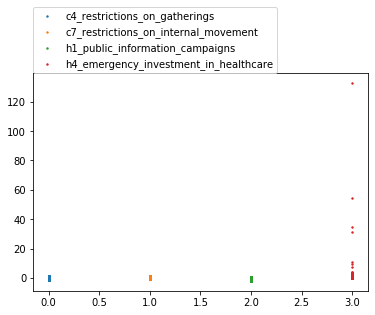

In [126]:
for i, c in enumerate(df.loc[:, column_search(df, 'n_')[:4]]):
    plt.scatter(len(df)*[i], (df.loc[:, c] - df.loc[:, c].mean()) / df.loc[:, c].std(), s=2,label=c)
plt.legend(loc=(0,1))


Time series variables with drift as baseline model : any columns with 'new' (cases, deaths, tests)
Time series variables with naive as baseline model : The complement to the drift baseline variables. 




The "Our World in Data" testing data isn't as reliable as the "Test tracker" testing data. 
This shows why it is important to be careful when selecting which representative from the
set of redundant features to use.

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

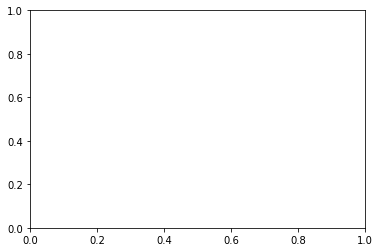

In [127]:
fig, ax = plt.subplots()
(100 * eda_data.set_index(['location', 'date']).isna().groupby(level=1).sum().loc[:, ['tests_cumulative_ttt', 'total_tests_owid']]
 / eda_data.location.nunique()).plot(ax=ax)
plt.title('Percentage of missing daily test reports')
plt.legend(loc=(0.5,0.8))
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

Death rate estimation, assuming 50% of people are asymptomatic and do not actually get tested or confirmed.

In [ ]:
today_data = df[df.time_index == df.time_index.max()]
death_rate = []
death_rate_estimation = []
for c_i in country_groupby(df):
    death_rate.append(100*df.loc[c_i,'new_deaths_weighted'].sum() / df.loc[c_i,'new_cases_weighted'].sum())
    death_rate_estimation.append(100*df.loc[c_i,'new_deaths_weighted'].sum() / (2*(df.loc[c_i,'new_cases_weighted'].sum())))

death_rate_estimation = np.array(death_rate_estimation)
death_rate = np.array(death_rate)

Likewise, the number of missing values for cases is also the worst for the OWID data set.

In [ ]:
eda_data.loc[:,['new_cases_test_tracker', 'new_cases_owid','cases_jhucsse']].isna().astype(int).groupby(eda_data.date).sum().plot()

Summary statistics of the "age" of the pandemic in each country.

In [128]:
print('The statistics of the age of the pandemic in each country, in units of days.\n')
print(df[df.time_index==df.time_index.max()].days_since_first_case.describe())

The statistics of the age of the pandemic in each country, in units of days.

count    150.000000
mean     112.013333
std       19.615426
min       41.000000
25%      101.000000
50%      110.000000
75%      118.000000
max      153.000000
Name: days_since_first_case, dtype: float64


In [129]:
government_responses = pd.concat((eda_data.loc[:, ['location','time_index','days_since_first_case']],
                                  eda_data.loc[:, column_search(eda_data, 'oxcgrt')].drop(
                                      columns=column_search(eda_data, 'flag')).iloc[:,2:10]), axis=1)

In [130]:
countries_with_all_responses = None
for i, country_indices in enumerate(country_groupby(government_responses)):
    government_responses.loc[country_indices,:] = government_responses.loc[country_indices,:].fillna(method='ffill')
    has_all_flags = (government_responses.loc[country_indices,:].max() == 0).sum()
    if has_all_flags != 0:
        pass
    else:
        if countries_with_all_responses is None:
            countries_with_all_responses = government_responses.loc[country_indices,:]
        else:
            countries_with_all_responses = pd.concat((countries_with_all_responses, government_responses.loc[country_indices,:]),axis=0)

see_if_country_has_all_dates =countries_with_all_responses.groupby('location').count().sort_values(by='time_index') 
drop_these_countries = np.unique(np.where(~(see_if_country_has_all_dates == df.time_index.nunique()))[0])
countries_with_all_responses = countries_with_all_responses[~countries_with_all_responses.location.isin(drop_these_countries)]

In [131]:
pd.Index(['days_with_infection']).append(countries_with_all_responses.columns[3:])

Index(['days_with_infection', 'c1_school_closing_oxcgrt',
       'c2_workplace_closing_oxcgrt', 'c3_cancel_public_events_oxcgrt',
       'c4_restrictions_on_gatherings_oxcgrt',
       'c5_close_public_transport_oxcgrt',
       'c6_stay_at_home_requirements_oxcgrt',
       'c7_restrictions_on_internal_movement_oxcgrt',
       'c8_international_travel_controls_oxcgrt'],
      dtype='object')

In [132]:
response_ranges = []
responses = pd.Index(['active_pandemic_dates']).append(countries_with_all_responses.columns[3:])
for country_indices in country_groupby(countries_with_all_responses):
    tmp = countries_with_all_responses.loc[country_indices,:].replace(to_replace=[0,0.], value=np.nan)
    for c in tmp.columns[2:]:
        active_range = tmp.set_index('time_index').loc[:,c].dropna()
        response_ranges.append(pd.IndexSlice[int(active_range.index.min()):int(active_range.index.max()+1)])
        
response_slices_df = pd.DataFrame(np.array(response_ranges).reshape(countries_with_all_responses.location.nunique(), -1),
                                 index=countries_with_all_responses.location.unique(), columns=responses)


In [133]:
start_dates = response_slices_df.applymap(lambda x : x.start)
stop_dates = response_slices_df.applymap(lambda x : x.stop)
start_dates.columns =[x[0] for x in response_slices_df.columns.str.split('_oxcgrt')]

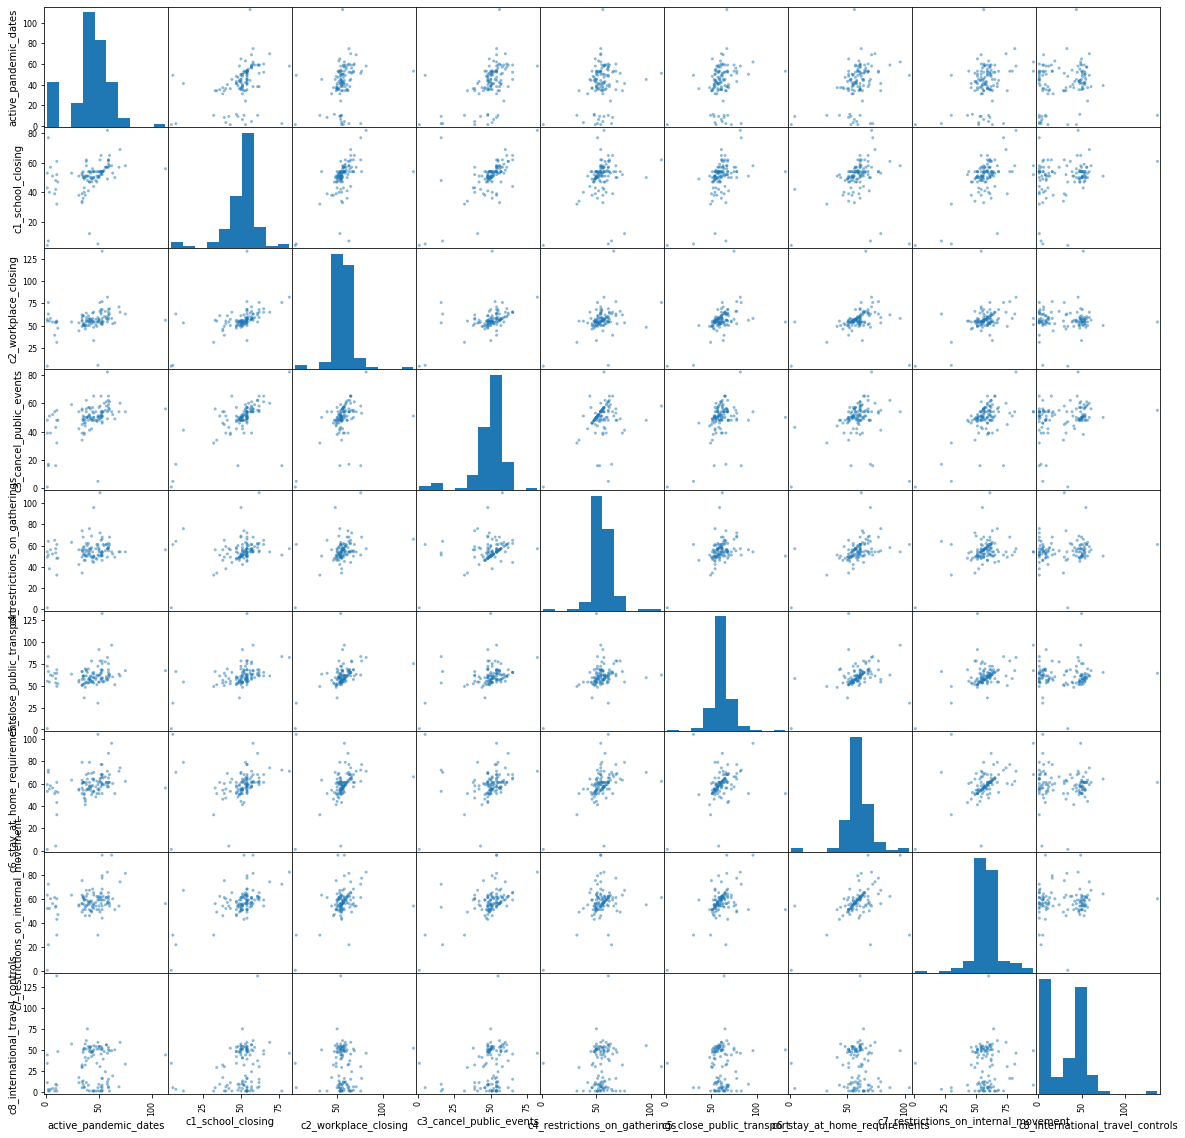

In [134]:
_ = pd.plotting.scatter_matrix(start_dates, figsize=(20,20))

In [135]:
average_response_date = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].mean(1)
average_response_date

Afghanistan      56.375
Albania          47.125
Algeria          57.500
Angola           58.000
Argentina        55.250
                  ...  
United States    44.875
Uzbekistan       55.375
Venezuela        61.500
Vietnam          39.000
Zimbabwe         54.500
Length: 109, dtype: float64

In [136]:
reaction_times = average_response_date.astype(int) - response_slices_df.applymap(lambda x : x.start).active_pandemic_dates

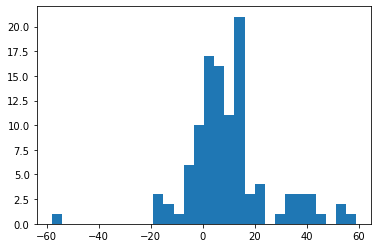

In [137]:
_ = plt.hist(reaction_times, bins=30)

In [138]:
# df[df.time_index==df.time_index.max()].total_deaths

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
23095    463.0
23096    479.0
23097    486.0
23098    489.0
23099    512.0
Name: total_cases_owid, Length: 23100, dtype: float64

In [152]:
death_rates = (100*eda_data.loc[:, column_search(eda_data, 'total_deaths')].iloc[:,0] / eda_data.loc[:, column_search(eda_data, 'total_cases')].iloc[:,0] ).loc[df.time_index==df.time_index.max()].values
death_rates = pd.Series(death_rates, index=df.location.unique())
death_rates

Afghanistan     2.051951
Albania         2.205514
Algeria         7.147651
Andorra         6.081871
Angola          4.918033
                 ...    
Venezuela       0.864625
Vietnam         0.000000
Yemen          26.577042
Zambia          0.769231
Zimbabwe        1.171875
Length: 150, dtype: float64

In [153]:
reaction_times

Afghanistan      22
Albania          -1
Algeria          22
Angola           -1
Argentina        13
                 ..
United States    43
Uzbekistan        1
Venezuela         8
Vietnam          37
Zimbabwe         -5
Length: 109, dtype: int64

In [154]:
countries_with_all_reactions = reaction_times.index.intersection(death_rates.index)

In [156]:
reaction_times.loc[countries_with_all_reactions]

Afghanistan      22
Albania          -1
Algeria          22
Angola           -1
Argentina        13
                 ..
United States    43
Uzbekistan        1
Venezuela         8
Vietnam          37
Zimbabwe         -5
Length: 109, dtype: int64

In [157]:
normalized_reactions = reaction_times.loc[countries_with_all_reactions]
normalized_reactions = (normalized_reactions.values - normalized_reactions.values.mean()) / normalized_reactions.values.std()


In [158]:
normalized_death_rates = death_rates.loc[countries_with_all_reactions]
normalized_death_rates = (normalized_death_rates - normalized_death_rates.mean()) / normalized_death_rates.std()

In [159]:
len(normalized_reactions)

109

In [160]:
normalized_death_rates

Afghanistan     -0.383976
Albania         -0.340737
Algeria          1.050821
Angola           0.423027
Argentina       -0.307935
                   ...   
United States    0.504397
Uzbekistan      -0.879438
Venezuela       -0.718291
Vietnam         -0.961743
Zimbabwe        -0.631779
Length: 109, dtype: float64

In [161]:
len(countries_with_all_reactions)

109

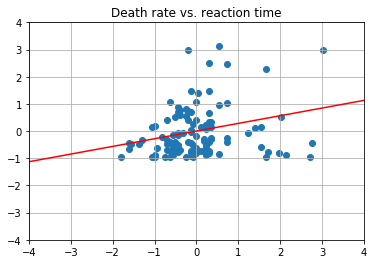

In [162]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(normalized_reactions, normalized_death_rates)

fig, ax = plt.subplots()
ax.scatter(normalized_reactions, 
            normalized_death_rates)
ax.plot(np.arange(-5,5), slope*np.arange(-5,5) + intercept, color='r')
ax.set_ylim([-4, 4])
ax.set_xlim([-4, 4])
ax.set_title('Death rate vs. reaction time')
ax.grid(True)

In [163]:
slope, intercept, r_value, p_value, std_err 

(0.282019622145951,
 4.06846789444273e-16,
 0.28332226012696216,
 0.002833082038730124,
 0.09228615699991817)

Late responders, first government action AFTER first case.

Early responders, first government action BEFORE first case.

In [164]:
first_day_responses_sum = countries_with_all_responses[countries_with_all_responses.days_since_first_case == 1].iloc[:, 3:].sum(axis=1)

In [165]:
countries_with_all_reactions

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Austria',
       'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados',
       ...
       'Tunisia', 'Uganda', 'Ukraine', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'Zimbabwe'],
      dtype='object', length=109)

In [166]:
countries_with_all_responses

,location,time_index,days_since_first_case,c1_school_closing_oxcgrt,c2_workplace_closing_oxcgrt,c3_cancel_public_events_oxcgrt,c4_restrictions_on_gatherings_oxcgrt,c5_close_public_transport_oxcgrt,c6_stay_at_home_requirements_oxcgrt,c7_restrictions_on_internal_movement_oxcgrt,c8_international_travel_controls_oxcgrt
0,Afghanistan,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
23095,Zimbabwe,149,91,2.0,1.0,2.0,3.0,1.0,1.0,2.0,4.0
23096,Zimbabwe,150,92,2.0,1.0,2.0,3.0,1.0,1.0,2.0,4.0
23097,Zimbabwe,151,93,2.0,1.0,2.0,3.0,1.0,1.0,2.0,4.0
23098,Zimbabwe,152,94,2.0,1.0,2.0,3.0,1.0,1.0,2.0,4.0


In [167]:
dates_of_first_responses = countries_with_all_responses[(countries_with_all_responses.location.isin(countries_with_all_reactions))&(countries_with_all_responses.days_since_first_case == 1)].time_index

In [168]:
dates_of_first_responses

34       34
202      48
343      35
675      59
812      42
         ..
21869     1
22230    54
22383    53
22486     2
23005    59
Name: time_index, Length: 109, dtype: int64

In [169]:
countries_with_all_responses.location.nunique()

109

In [184]:
dates_of_first_responses.min()

1

0.06187200499088586 2.7855732549910153 0.2833222601269619 0.0028330820387301465 0.020246568387832294


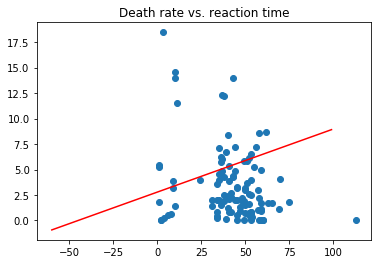

In [170]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(reaction_times.loc[countries_with_all_reactions],death_rates.loc[countries_with_all_reactions])

plt.scatter(dates_of_first_responses, 
            death_rates.loc[countries_with_all_reactions])
plt.plot(np.arange(-60,100), slope*np.arange(-60,100) + intercept, color='r') 
plt.title('Death rate vs. reaction time')
print(slope, intercept, r_value, p_value, std_err)

In [171]:
early_responders_args = first_day_responses_sum[first_day_responses_sum > 0].index
early_responders = countries_with_all_responses.loc[early_responders_args,:].location.values
print('\n The early responders:\n')
print(early_responders)


 The early responders:

['Afghanistan' 'Albania' 'Angola' 'Azerbaijan' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belize' 'Bhutan' 'Bolivia' 'Botswana' 'Chad' 'China'
 'Colombia' 'Croatia' 'Cuba' 'Cyprus' 'Djibouti' 'Ecuador' 'El Salvador'
 'Eritrea' 'Ethiopia' 'Fiji' 'France' 'Gabon' 'Georgia' 'Ghana'
 'Guatemala' 'Guinea Bissau' 'Guyana' 'Haiti' 'India' 'Indonesia' 'Iraq'
 'Israel' 'Italy' 'Jamaica' 'Kazakhstan' 'Kenya' 'Kosovo' 'Kuwait'
 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Madagascar' 'Mauritius' 'Mexico'
 'Mongolia' 'Nepal' 'New Zealand' 'Oman' 'Pakistan' 'Panama'
 'Papua New Guinea' 'Peru' 'Philippines' 'Qatar' 'Romania' 'Russia'
 'Rwanda' 'San Marino' 'Serbia' 'Seychelles' 'Sierra Leone' 'Singapore'
 'South Africa' 'South Sudan' 'Sri Lanka' 'Sudan' 'Suriname'
 'Trinidad And Tobago' 'Tunisia' 'Uganda' 'United Arab Emirates'
 'Uzbekistan' 'Venezuela' 'Zimbabwe']


In [172]:
late_responders_args = first_day_responses_sum[first_day_responses_sum == 0].index
late_responders = countries_with_all_responses.loc[late_responders_args,:].location.values
print('The late responders:\n')
print(late_responders)

The late responders:

['Algeria' 'Argentina' 'Austria' 'Bosnia And Herzegovina' 'Brazil'
 'Burkina Faso' 'Costa Rica' 'Denmark' 'Dominican Republic' 'Egypt'
 'Greece' 'Honduras' 'Hungary' 'Ireland' 'Ivory Coast' 'Jordan'
 'Lithuania' 'Morocco' 'Netherlands' 'Nigeria' 'Paraguay' 'Poland'
 'Portugal' 'Saudi Arabia' 'Slovenia' 'Spain' 'Thailand' 'Ukraine'
 'United Kingdom' 'United States' 'Vietnam']


In [173]:
late_df = df[df.location.isin(late_responders)]
early_df = df[df.location.isin(early_responders)]

In [174]:
early_df_present_day = early_df[early_df.time_index == df.time_index.max()]
late_df_present_day = late_df[late_df.time_index == df.time_index.max()]

In [175]:
d_rate = pd.Series(death_rates, index=df.location.unique())

In [176]:
early_d_rates = d_rate.loc[early_df_present_day.location.unique()]
late_d_rates = d_rate.loc[late_df_present_day.location.unique()]

In [177]:
_ = plt.scatter(early_d_rates, early_df_present_day.total_cases.values, label='Early responders')
_ = plt.scatter(late_d_rates, late_df_present_day.total_cases.values, label='Late responders')
_ = plt.xlabel('Estimated death rate, (% of total cases)')
_ = plt.ylabel('Number of cases per million people')
_ = plt.legend(loc=(0.6,0.2))
_ = plt.yscale('log')
# plt.plot(np.sort(death_rate))

AttributeError: 'DataFrame' object has no attribute 'total_cases'

Does not seem to be any obvious partition between early and late responders.

In [180]:
dftmp = pd.concat((df, (eda_data.loc[:, column_search(eda_data, 'total_deaths')].iloc[:,0] / eda_data.loc[:, column_search(eda_data, 'total_cases')].iloc[:,0] ).to_frame(name='death_rates')),axis=1)
xcr = dftmp.corr()

In [181]:
xcr.loc['death_rates',:].sort_values()

h3_contact_tracing           -0.144263
h2_testing_policy            -0.072650
population_density           -0.063916
tests_units_samples_tested   -0.060130
cvd_death_rate               -0.056325
                                ...   
days_since_first_case         0.133546
time_index                    0.139525
new_deaths_weighted           0.183643
log_new_deaths_weighted       0.275421
death_rates                   1.000000
Name: death_rates, Length: 67, dtype: float64

In [ ]:
# m1_wildcard (-1) is nan, -2 is deaths rates.
xcr.loc['death_rates',:].sort_values()[:-2].plot.hist()

In [ ]:
ncountrylist = []
for n in range(df.time_index.min(), df.time_index.max()+1):
    ncountrylist.append((df.location.nunique()-df[df.days_since_first_case > n].location.nunique()))
plt.plot(df.date.unique(), ncountrylist)
plt.ylim([0, df.location.nunique()+1])
plt.title('')
plt.ylabel('Number of infected countries')
plt.xlabel('Date')
_ = plt.show()

In [ ]:
ncountrylist = []
for n in range(0, df.time_index.nunique()):
    ncountrylist.append(100*(df.location.nunique()-df[df.days_since_first_case > n].location.nunique())/df.location.nunique())
plt.plot(df.date.unique(), ncountrylist)
plt.ylim([0, 100])
plt.title('Number of reporting countries with cases')
plt.ylabel('Percentage of countries')
plt.xlabel('Date')
_ = plt.show()

In [ ]:
maxima_of_new_cases_weighted_series

In [ ]:
dftmp.location.nunique()

In [ ]:
df.groupby('date').mean().new_cases_weighted.plot()

In [ ]:
dftmp = df[df.time_index >= 40]
dftmp = dftmp[dftmp.location.isin(dftmp[dftmp.days_since_first_case > 60].location.unique())]
maxima_of_new_cases_weighted_series = dftmp.set_index(['time_index','location']).new_cases_weighted.unstack().max().sort_values().index
dftmp.set_index(['time_index','location']).loc[pd.IndexSlice[:, maxima_of_new_cases_weighted_series],:].new_cases_weighted.unstack().plot(legend=False,figsize=(10,10))
# plt.legend(loc=(1,0))

